![seQuencing logo](../images/sequencing-logo.*)

# Introduction

`sequencing` is designed to make it easy to create and simulate time-dependent Hamiltonians.

This notebook is intended to show, at a high level, some of what `sequencing` can do. For a more in-depth look at the inner workings of `sequencing` and more advanced applications, check out the [tutorials](../tutorials/tutorials.rst).

In [1]:
# %matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

from sequencing import Transmon, System, get_sequence, sync, delay

## Create a quantum `Mode` and `System`

In [2]:
qubit = Transmon('qubit', levels=3)
qubit.anharmonicity = -200e-3 # GHz
# A System can contain many interacting or non-interacting Modes,
# but here we have just one.
system = System('system', modes=[qubit])

### Inspect and adjust `Pulse` parameters

In [3]:
print(list(qubit.pulses), end='\n\n')
print(qubit.gaussian_pulse, end='\n\n')
print(qubit.gaussian_pulse.to_json(dumps=True))

['smoothed_constant_pulse', 'gaussian_pulse']

GaussianPulse(name='gaussian_pulse', cls='sequencing.pulses.GaussianPulse', amp=1.0, detune=0.0, phase=0.0, noise_sigma=0.0, noise_alpha=0.0, scale_noise=False, sigma=10, chop=4, drag=0.0)

{
  "amp": 1.0,
  "chop": 4,
  "cls": "sequencing.pulses.GaussianPulse",
  "detune": 0.0,
  "drag": 0.0,
  "name": "gaussian_pulse",
  "noise_alpha": 0.0,
  "noise_sigma": 0.0,
  "phase": 0.0,
  "scale_noise": false,
  "sigma": 10
}


### Plot the `Pulse` waveform

<IPython.core.display.Javascript object>


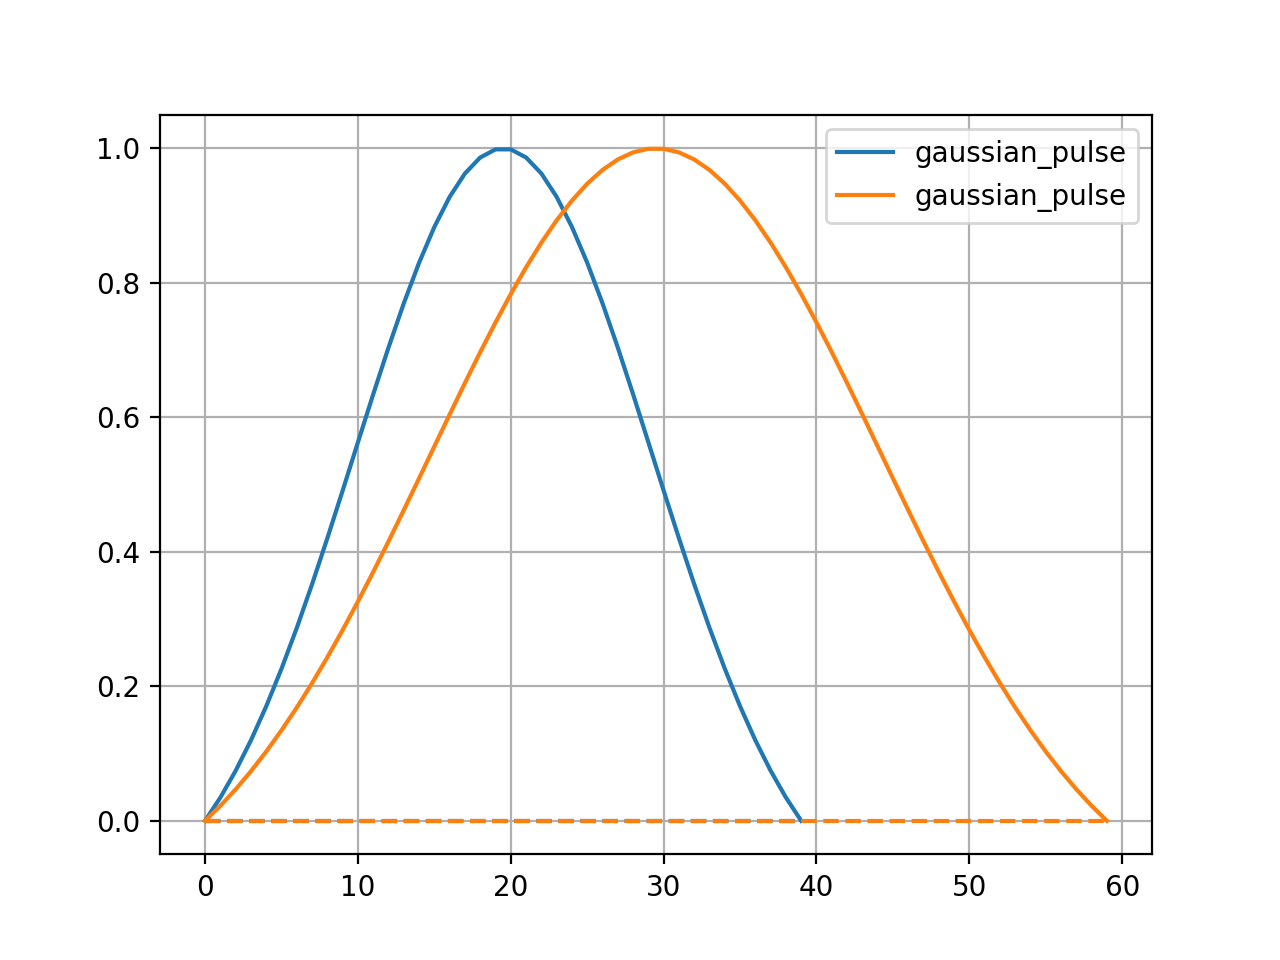

In [4]:
ax = qubit.gaussian_pulse.plot()
# Adjust the Gaussian width, sigma
qubit.gaussian_pulse.sigma = 15 # ns
ax = qubit.gaussian_pulse.plot(ax=ax)

The values plotted above represent time-dependent coefficients for the `x` and `y` operators defined by the `Mode` class:

In [5]:
print('qubit.x:')
display(qubit.x)
print('qubit.y:')
display(qubit.y)

qubit.x:


Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.         1.         0.        ]
 [1.         0.         1.41421356]
 [0.         1.41421356 0.        ]]

qubit.y:


Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0.+0.j         0.-1.j         0.+0.j        ]
 [0.+1.j         0.+0.j         0.-1.41421356j]
 [0.+0.j         0.+1.41421356j 0.+0.j        ]]

If we temporarily set the number of levels in our `Transmon` to 2, we will see that `x` and `y` take the familiar form of the Pauli operators, $\sigma_x$ and $\sigma_y$.

In [6]:
with qubit.temporarily_set(levels=2):
    print('qubit.x:')
    display(qubit.x)
    print('qubit.y:')
    display(qubit.y)

qubit.x:


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 1.]
 [1. 0.]]

qubit.y:


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.+0.j 0.-1.j]
 [0.+1.j 0.+0.j]]

## Simulate a Gaussian $\pi$ pulse

Define the initial state of the system, and operators for which you would like to compute expectation values.

In [7]:
init_state = qubit.fock(0) # |g> state
g_op = qubit.fock_dm(0) # |g><g| operator
e_op = qubit.fock_dm(1) # |e><e| operator

### Generate the pulse sequence

And plot the time-dependent Hamiltonian coefficients.

<IPython.core.display.Javascript object>


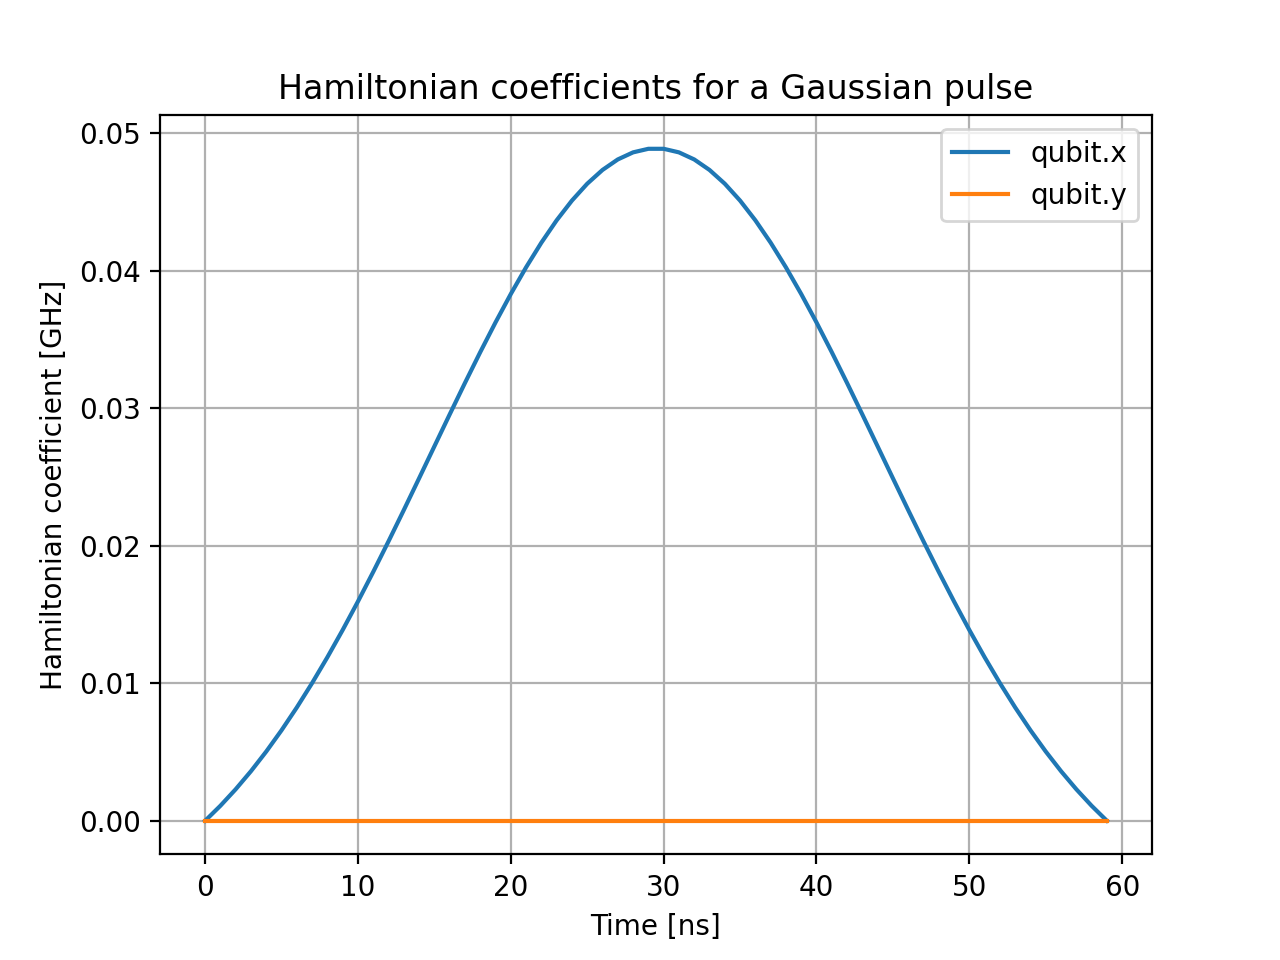

In [8]:
# Define the pulse sequence
seq = get_sequence(system)
qubit.rotate_x(np.pi)

fig, ax = seq.plot_coefficients(subplots=False)
ax.set_title('Hamiltonian coefficients for a Gaussian pulse')
ax.set_xlabel('Time [ns]')
ax.set_ylabel('Hamiltonian coefficient [GHz]');

### Simulate the pulse sequence

And plot expectation values vs. time.

<IPython.core.display.Javascript object>


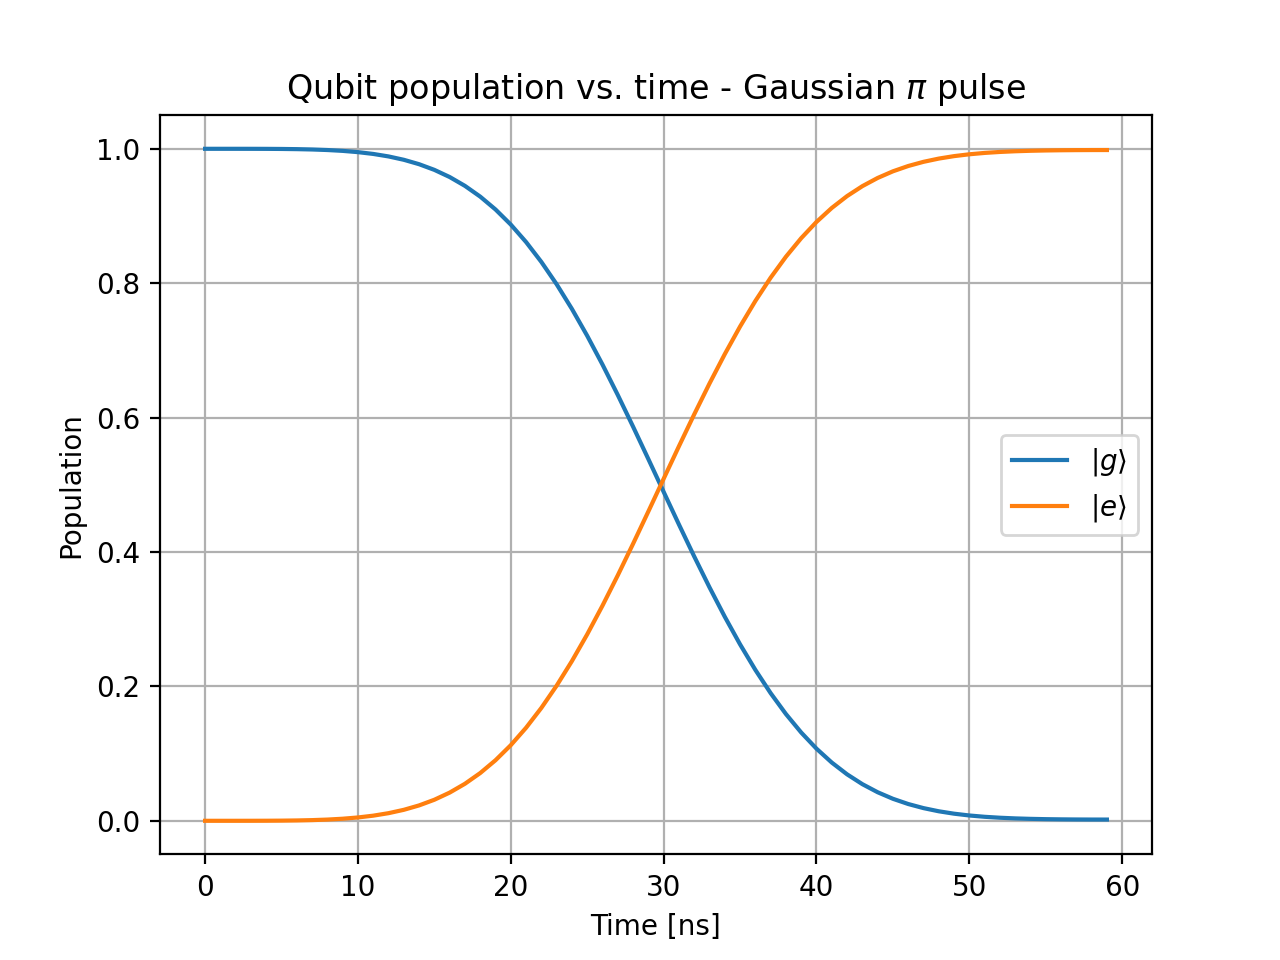

In [9]:
# Run the master equation simulation
result = seq.run(init_state, e_ops=[g_op, e_op])

fig, ax = plt.subplots()
ax.plot(result.times, result.expect[0], label='$|g\\rangle$')
ax.plot(result.times, result.expect[1], label='$|e\\rangle$')
ax.set_ylabel('Population')
ax.set_xlabel('Time [ns]')
ax.set_title('Qubit population vs. time - Gaussian $\pi$ pulse')
ax.grid(True)
ax.legend(loc=0);

## Simulate a $T_1$ measurement

In [10]:
def fit_exp_decay(xs, ys):
    slope, offset = np.polyfit(xs, np.log(ys), 1)
    amp = np.exp(offset)
    tau = -1 / slope
    return amp, tau

The pulse sequence for a $T_1$ measurement is:

```
for delay_time in delay_times:
    Rx(pi) # excite the qubit from |g> -> |e>
    delay(delay_time)
    measure P(|e>) 
```

Because there are no operations on the qubit after the delay time, we can simulate the whole measurement in a single master equation simulation.

### Execute the sequence

In [11]:
qubit.t1 = 10e3 # 10e3 ns == 10 us

tmax = 40e3 # maximum delay time, 40 us

seq = get_sequence(system)
# T1 sequence
qubit.rotate_x(np.pi)
delay(tmax)

result = seq.run(init_state, e_ops=[g_op, e_op])

ts = result.times / 1e3 # [us]
g_pops = result.expect[0] # P(|g>)
e_pops = result.expect[1] # P(|e>)

### Analyze the results

Fit to the model for energy relaxation, $P_e(t) = e^{-\frac{t}{T_1}}$, by fitting $\log(P_e)$ vs. $t$ to a line.

In [12]:
# Only fit P(|e>) starting after the pi pulse is finished
t0 = qubit.gaussian_pulse.sigma * qubit.gaussian_pulse.chop
fit_ts = ts[t0:]
fit_amp, fit_t1 = fit_exp_decay(fit_ts, e_pops[t0:])

Plot the results and the fit.

<IPython.core.display.Javascript object>


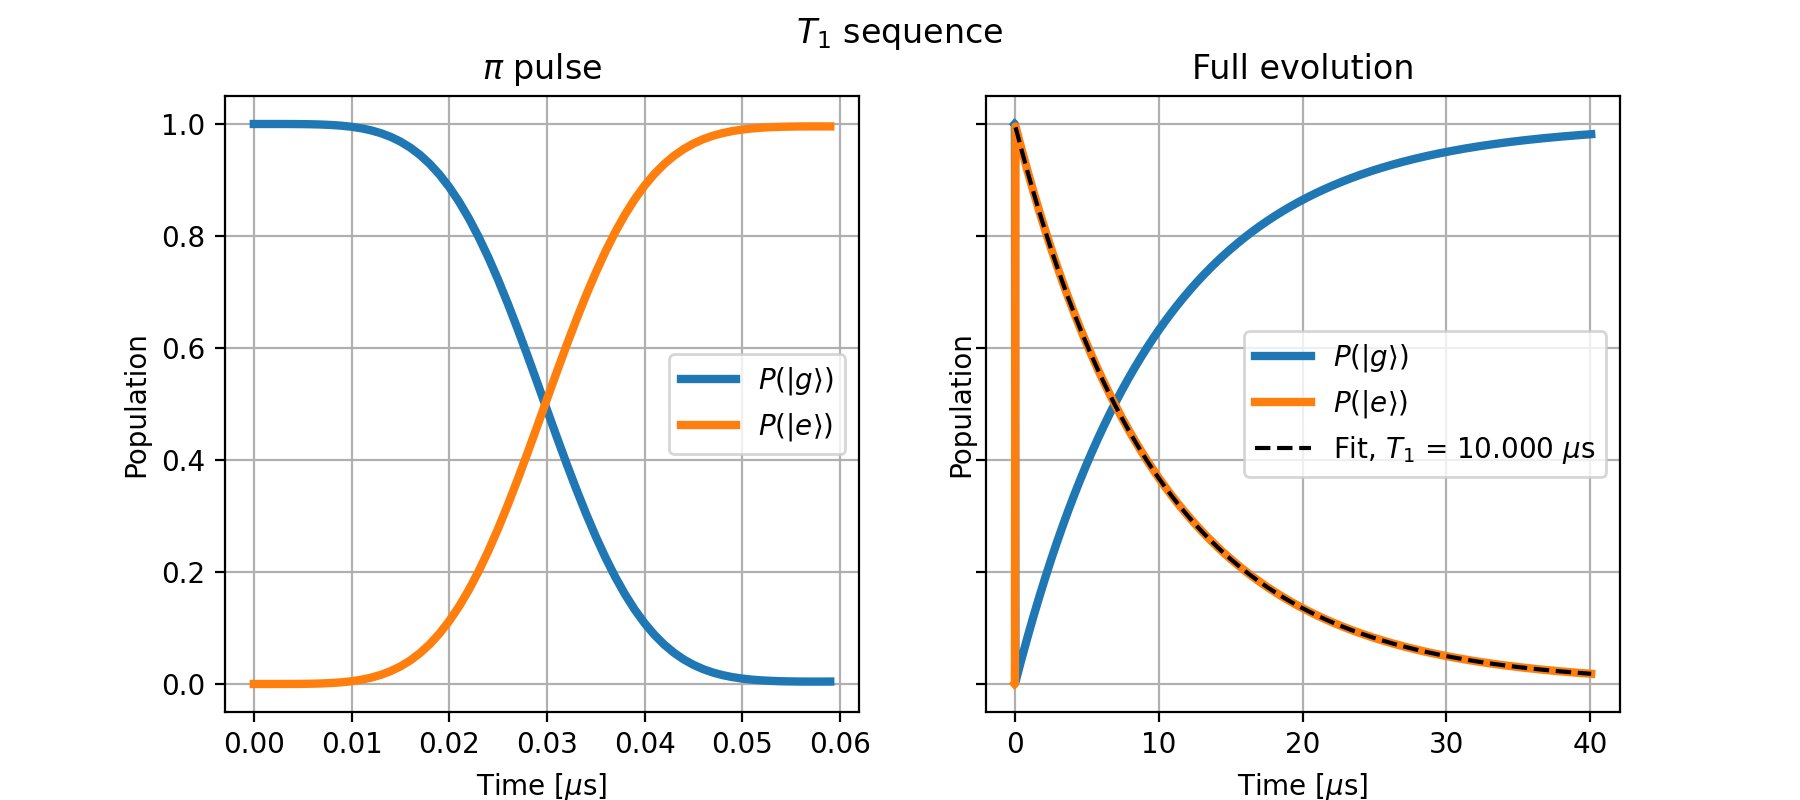

In [13]:
fig, (ax, bx) = plt.subplots(1, 2, sharey=True, figsize=(9,4))
# plot population vs. time during the pi pulse
ax.plot(ts[:t0], g_pops[:t0], lw=3, label='$P(|g\\rangle)$')
ax.plot(ts[:t0], e_pops[:t0], lw=3, label='$P(|e\\rangle)$')
ax.set_title('$\pi$ pulse')

# plot population vs. time for the whole sequence
bx.plot(ts, g_pops, lw=3, label='$P(|g\\rangle)$')
bx.plot(ts, e_pops, lw=3, label='$P(|e\\rangle)$')
bx.plot(fit_ts, np.exp(-fit_ts / fit_t1), 'k--', label=f'Fit, $T_1$ = {fit_t1:.3f} $\mu$s')
bx.set_title('Full evolution')
for a in (ax, bx):
    a.set_xlabel('Time [$\mu$s]')
    a.set_ylabel('Population')
    a.grid(True)
    a.legend(loc=0)
fig.suptitle('$T_1$ sequence');

## Simulate a $T_2$ echo measurement

The pulse sequence for a $T_2$ echo measurement is:

```
for delay_time in delay_times:
    Ry(pi / 2) # generate a superposition state |g> + e^(i*phi)|e>
    delay(delay_time / 2)
    Rx(pi) # perform the echo
    delay(delay_time / 2)
    Ry(pi / 2) # rotate back to one of the poles of the Bloch sphere
    measure P(|e>)
```

In this case, unlike for the $T_1$ measurement, we need to perform a separate master equation simulation for each delay time.

### Visualize the $T_2$ echo sequence

<IPython.core.display.Javascript object>


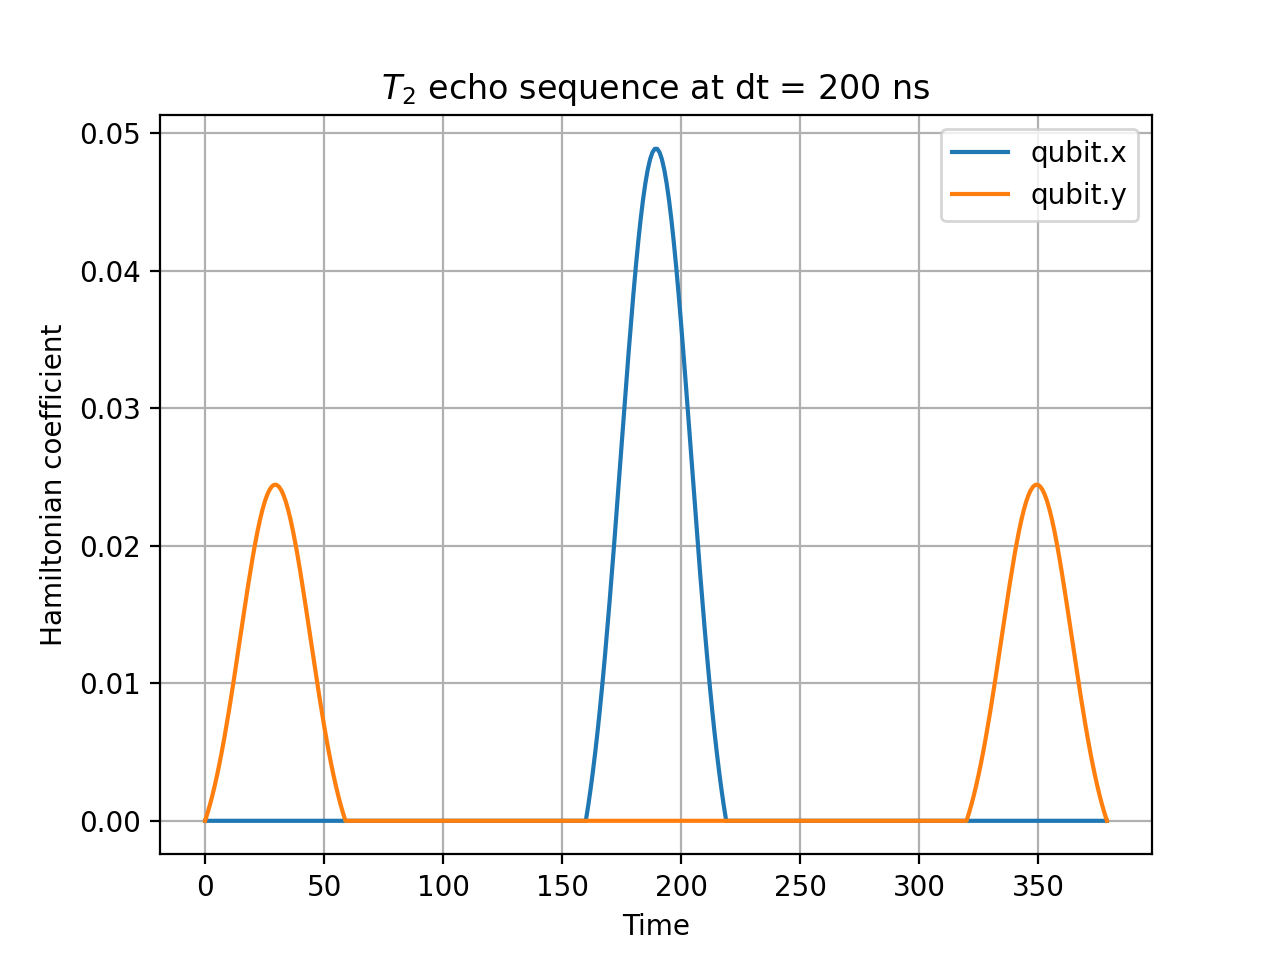

In [14]:
dt = 200 # ns

seq = get_sequence(system)

qubit.rotate_y(np.pi/2)
delay(dt/2)
qubit.rotate_x(np.pi)
delay(dt/2)
qubit.rotate_y(np.pi/2)

fig, ax = seq.plot_coefficients(subplots=False)
ax.set_title(f'$T_2$ echo sequence at dt = {dt} ns');

### Execute the sequence

In [15]:
qubit.t2 = 10e3 # 10 us
qubit.t1 = np.inf # Pure dephasing only

delay_times = 1e3 * np.linspace(0, 30, 11) # sweep delay from 0 to 30 us

g_pops = []
e_pops = []

print('Running dt [us] =', end=' ')
for dt in delay_times:
    print(dt/1e3, end=' ')
    
    seq = get_sequence(system)
    
    # T2 echo sequence
    qubit.rotate_y(np.pi/2)
    delay(dt/2)
    qubit.rotate_x(np.pi)
    delay(dt/2)
    qubit.rotate_y(np.pi/2)
    
    result = seq.run(init_state, e_ops=[g_op, e_op])
    g_pops.append(result.expect[0][-1])
    e_pops.append(result.expect[1][-1])

Running dt [us] = 0.0 3.0 6.0 9.0 12.0 15.0 18.0 21.0 24.0 27.0 30.0 

### Analyze the results

In [16]:
ts = delay_times / 1e3 # [us]
# rescale |e> population to decay from 1 to 0 for fitting
ys = 2 * np.array(e_pops) - 1
fit_amp, fit_t2 = fit_exp_decay(ts, ys)
# invert the rescaling for plotting
fit_ys = (1 + np.exp(-ts / fit_t1)) / 2

<IPython.core.display.Javascript object>


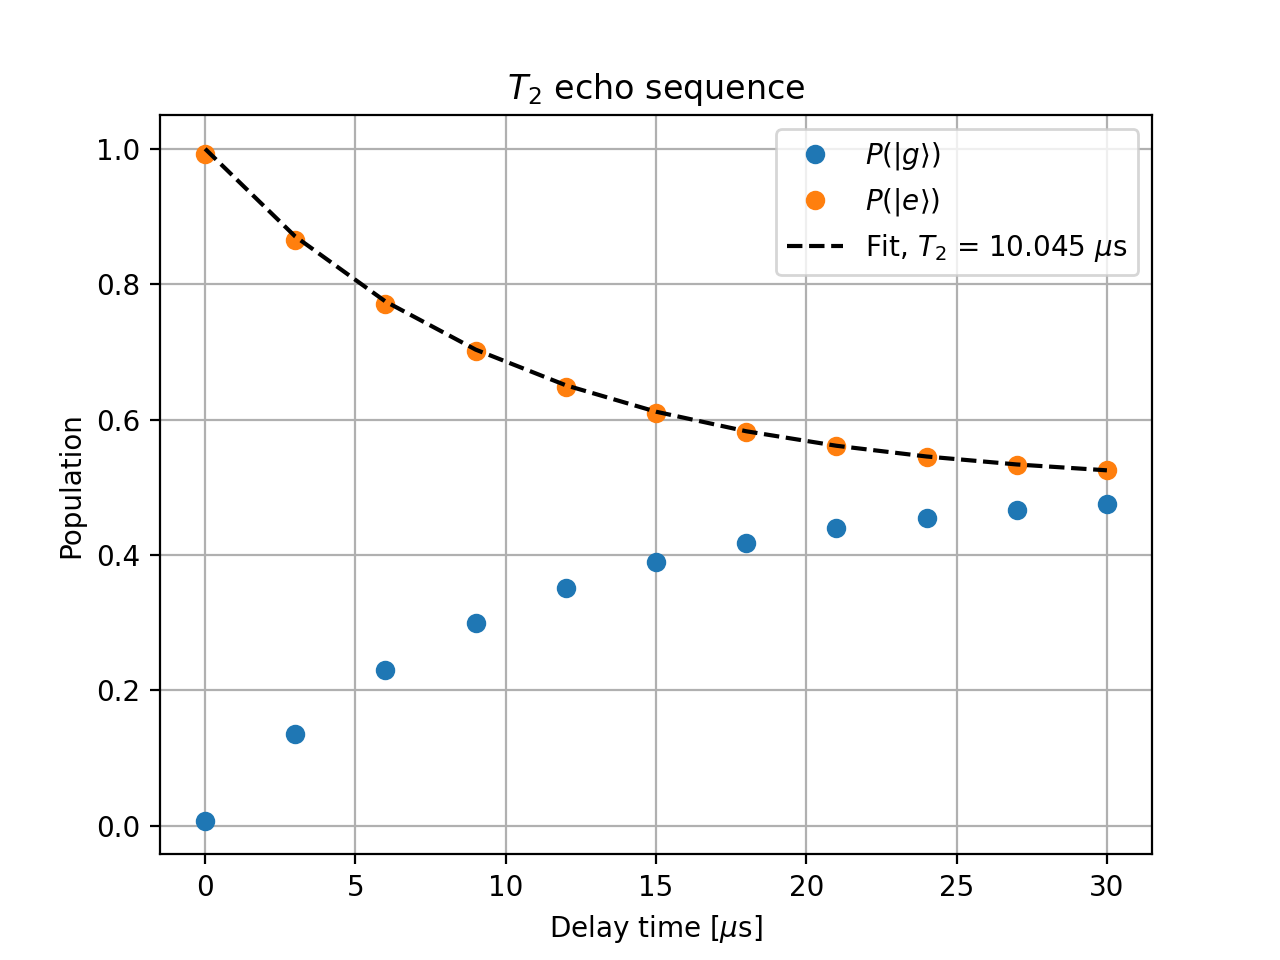

In [17]:
fig, ax = plt.subplots()
ax.plot(ts, g_pops, 'o', label='$P(|g\\rangle)$')
ax.plot(ts, e_pops, 'o', label='$P(|e\\rangle)$')
ax.plot(ts, fit_ys, 'k--', label=f'Fit, $T_2$ = {fit_t2:.3f} $\mu$s')
ax.set_xlabel('Delay time [$\mu$s]')
ax.set_ylabel('Population')
ax.set_title('$T_2$ echo sequence')
ax.grid(True)
ax.legend(loc=0);

## Learn more

For more in depth tutorials and examples, see [Tutorials](../tutorials/tutorials.rst).

In [18]:
from qutip.ipynbtools import version_table
version_table()

Software,Version
QuTiP,4.5.2
Numpy,1.19.2
SciPy,1.5.2
matplotlib,3.2.2
Cython,0.29.21
Number of CPUs,4
BLAS Info,INTEL MKL
IPython,7.19.0
Python,"3.7.0 (default, Jun 28 2018, 08:04:48) [MSC v.1912 64 bit (AMD64)]"
OS,nt [win32]
